# Social Network Analysis with Python

***

<p style="margin-top:1em;margin-bottom:1em;margin-right:1em;margin-left:1em;background-color:#F9F9F9;font-family:'Source Sans Pro','Helvetica Neue',Arial,sans-serif;color:#34495e;padding-top:1em;padding-bottom:1em;padding-right:1em;padding-left:2em;border-left-width:4px;border-left-style:solid;border-left-color:#DDD;box-shadow:0 1px 1px rgba(0, 0, 0, 0.125);border-color:#0074D9;" ><b>Note:</b> Please make sure this ipynb (or html) file is in the same directory as the 'svg' folder for network visualisations to appear.<p></p>

***

## Objectives of this lab:
- Data wrangling with Python
- Formatting Data for SNA
- SNA with networkx (micro, macro level metrics)
- Network visualization

## 1. Preparing Data 

The first step is getting our Social Network data. For the purpose of this lab we will use the Enron Database. This dataset was collected and prepared by the CALO Project (A Cognitive Assistant that Learns and Organizes). It contains data from about 150 users, mostly senior management of Enron, organized into folders. The corpus contains a total of about 0.5M messages. This data was originally made public, and posted to the web, by the Federal Energy Regulatory Commission during its investigation.

As part of their inquiries, The Federal Energy Regulatory Commission used an extensive collection of emails from Enron employees. The Enron corpus is one of the only publicly available collections of emails available for research. This dataset also provides a fascinating playground for citizen data scientists.


You can download the Database from the following link: http://www.cs.cmu.edu/~enron/


The Original Enron Dataset contains a set of folders that organizes a collection of mailboxes by person and folder. Data wrangling is a routine problem, and this section should give you some perspective and some appreciation for it.



### Getting all the emails

The main folder is maildir, which holds all the personal accounts. Our first task is to load the required libraries and create a list of available emails. 

You will need to get all files in the inboxes of users. To do that, you need to iterate on all subdirectories 'inbox' within the maildir folder. It is useful to store the path of the files in a data structure before starting to read each file. 

The choice of the inboxes garantees retrieving all possible exchanges, including multi destination emails   

In [3]:
# Import needed libraries
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import random, re, textwrap
from time import sleep
from functools import wraps
import seaborn as sns
import nxviz as nv
import community
from collections import Counter
from IPython.display import display, HTML, SVG

In [5]:
# Get paths to all subdirectories 'inbox'
def get_paths(data_dir, has_sent):
    paths = []
    for d in (d for d in data_dir.iterdir() if d.is_dir()):
        if (d / 'inbox').is_dir() and ((d / 'sent').is_dir() or not has_sent):
            for f in (f for f in (d / 'inbox').iterdir() if f.is_file()):
                paths.append(str(f))
    print(len(paths), "file found.")
    return paths

In [6]:
# Dataset directory
data_dir = Path("maildir")

# Get the list of paths of all emails in the 'inbox' folders: list of str
paths = get_paths(data_dir, False)

41509 file found.


In [7]:
# Verification
print("size:", len(paths))
print("10 random results:")
for i in range(10):
    i = random.randrange(0, len(paths) - 1)
    print(i, "th path:\t", paths[i], sep = "")

size: 41509
10 random results:
12976th path:	maildir\hendrickson-s\inbox\62
41143th path:	maildir\ybarbo-p\inbox\593
5789th path:	maildir\crandell-s\inbox\38
17623th path:	maildir\lay-k\inbox\1713
39368th path:	maildir\white-s\inbox\45
7669th path:	maildir\dean-c\inbox\315
674th path:	maildir\baughman-d\inbox\164
8016th path:	maildir\dean-c\inbox\636
8037th path:	maildir\dean-c\inbox\660
29994th path:	maildir\salisbury-h\inbox\3


We are only interested by Employees who have sent at least one email (i.e. have a subdirectory 'sent'). 

In [8]:
# Get the list of paths of all emails in the 'inbox' folders
# of employees with 'sent' folder: list of str
paths = get_paths(data_dir, True)

28987 file found.


In [9]:
# Verification
print("size:", len(paths))
print("10 random results:")

for i in range(10):
    i = random.randrange(0, len(paths) - 1)
    print(i, "th path:\t", paths[i], sep = "")

size: 28987
10 random results:
12309th path:	maildir\jones-t\inbox\812
13852th path:	maildir\lavorato-j\inbox\245
13625th path:	maildir\keavey-p\inbox\560
23802th path:	maildir\shively-h\inbox\18
2739th path:	maildir\buy-r\inbox\869
5422th path:	maildir\dasovich-j\inbox\367
1083th path:	maildir\beck-s\inbox\545
8972th path:	maildir\giron-d\inbox\199
7768th path:	maildir\donohoe-t\inbox\445
12116th path:	maildir\jones-t\inbox\547


Make sure to clean your data from any System file etc. Then read the files within the subdirectories. Beware of encoding problems.

In [10]:
# Read all the emails into a dictionary or a data structure of your choice
# You can use the path or username as key and the content of the email as value.

# decorator to display a progress bar
def progressBar(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        print('|0%|', '_' * 50,'|100%|',sep="", end="\n|  |")
        res = func(*args, **kwargs)
        print("|done|")
        return res
    return wrapper

# get emails
@progressBar
def get_emails_contents(paths):
    
    # data dictionary: {'path/to/email':'email content'}
    data = {}
    
    # for displaying progress
    step = set(map(lambda x: int(round(x * len(paths) / 50)) - 1, range(1, 51)))
    advance = lambda x: print("#", end="") if x in step else None
    
    # loop over paths
    for ind, path in enumerate(paths):
        
        # open file and add its content to dictionary
        with open(path, 'r') as current_file:
            data[path] = current_file.read()

        # progress
        advance(ind)
        
    return data

In [11]:
emails_contents = get_emails_contents(paths)

|0%|__________________________________________________|100%|
|  |##################################################|done|


In [12]:
#verification
# read few first lines from random file:
i = random.randrange(0, len(paths) - 1)
print("path:\n\t", paths[i])
print("content (six first lines):\n", textwrap.indent('\n'.join(emails_contents[paths[i]].split('\n')[:6]), prefix="\t"))

path:
	 maildir\taylor-m\inbox\129
content (six first lines):
 	Message-ID: <26370229.1075858614627.JavaMail.evans@thyme>
	Date: Tue, 9 Oct 2001 06:08:12 -0700 (PDT)
	From: sara.shackleton@enron.com
	To: legal <.taylor@enron.com>, c..koehler@enron.com
	Subject: RE: The Chase Manhattan Bank - EOL
	Mime-Version: 1.0


### Getting Employees username/emails

We'd also like to get a list of Employees' username (name on the folders) and their emails. Clean your data accordingly. 

Note: You will need to access the first file from each subdirectory 'sent' in order to retrieve the email of an Employee. We use the 'sent' subdirectory because an email can have only one sender but multiple recipients.

You can use Regular Expressions to retrieve the emails from the files.

In [13]:
# Get a list of usernames / emails from Sent emails
def get_usernames(data_dir):
    return[d.name for d in data_dir.iterdir() if (d / 'inbox').is_dir() and (d / 'sent').is_dir()]

def pattern_match(email):
    pattern = re.compile('From:\s[\w\.\']+@enron\.com')
    return pattern.findall(email)[0][6:]

def get_emails(data_dir, usernames):
    email = None
    emails = {}
    for d in (data_dir / u for u in usernames):
        with open(d / 'sent' / '1', 'r') as first_file:
            emails[d.name] = pattern_match(first_file.read())
    return emails

In [14]:
usernames = get_usernames(data_dir)
emails = get_emails(data_dir, usernames)

print("number of usernames:", len(usernames))
print("number of emails:", len(emails))

number of usernames: 81
number of emails: 81


In [15]:
# print 10 random usernames and their emails
randselect = []
for i in range(10):
    i = random.randrange(0, len(usernames) - 1)
    randselect.append([i, usernames[i], emails[usernames[i]]])
randselect = pd.DataFrame(randselect, columns=['number', 'username', 'email'])
display(randselect)

,number,username,email
0,47,may-l,larry.may@enron.com
1,41,lewis-a,andrew.lewis@enron.com
2,70,sturm-f,fletcher.sturm@enron.com
3,46,martin-t,laura.vuittonet@enron.com
4,54,pereira-s,susan.pereira@enron.com
5,60,ruscitti-k,kevin.ruscitti@enron.com
6,63,scott-s,susan.scott@enron.com
7,24,giron-d,darron.giron@enron.com
8,67,shively-h,hunter.shively@enron.com
9,61,sager-e,elizabeth.sager@enron.com


The idea here is that, instead of having paths or usernames in your data structure containing the received emails, we will have emails.

You need to transform your data structure using the usernames/emails list you just created, and don't forget to clean your emails in order to only keep strings before the '@' character

In [16]:
# Transform data structure to have emails rather than usernames or paths
def update_keys(emails_contents, emails):
    keys = list(emails_contents.keys())
    new_key = None
    for key in keys:
        new_key = emails[Path(key).parts[1]].split("@")[0] + ' ' + Path(key).name
        emails_contents[new_key] = emails_contents.pop(key)

In [17]:
# emails_backup = emails_contents.copy()
update_keys(emails_contents, emails)

In [18]:
# read first lines of random file:
i = random.randrange(0, len(paths) - 1)
random_key = list(emails_contents.keys())[i]
print("email+index:\n\t", random_key)
print("content:\n", textwrap.indent('\n'.join(emails_contents[random_key].split('\n')[:6]), prefix="\t"))

email+index:
	 clint.dean 868
content:
 	Message-ID: <5135889.1075852158508.JavaMail.evans@thyme>
	Date: Tue, 9 Oct 2001 08:06:52 -0700 (PDT)
	From: julie.kearney@enron.com
	To: center.dl-portland@enron.com
	Subject: Josie Jarnagin
	Mime-Version: 1.0


### Getting Sender and Receiver information

At this point you have:
- A Data structure containing the email of the destination ('to') and the content of the email
- A list of all usernames / emails

We now need to create a pands Dataframe (input for our network Analysis) that contains emails of a sender and receiver of every email in your data structure. 

The Dataframe will be created using a list of [sender, receiver].

Note: don't forget to clean your emails in order to only keep strings before the '@' character

In [19]:
# Create a list of [sender, receiver]
# Use Regex to extract the email of the Sender of each email ('From')
'''
Since we are only interested in Enron employees, we will filter out adresses from different domains
To avoid any complications dealing with external adresses, we will replace them with numpy.nan
We will remove them later when we create our Pandas DataFrame using the methode dropna()
'''
from numpy import nan

def pattern_match2(email):
    # pattern = re.compile('From:\s[\w\.\'\-\<\> ]+@[\w\.\'-]+')
    # we'll extract enron only emails
    pattern = re.compile('From:\s[\w\.\']+@enron\.com')
    try:
        res = pattern.findall(email)[0][6:]
    except IndexError:
        res = "NA"
    return res

@progressBar
def get_sender_receiver(emails_contents):
    
    sender_receiver_list = []
    sender_email = receiver_email = ''
    
    step = set(map(lambda x: int(round(x * len(emails_contents) / 50)) - 1, range(1, 51)))
    advance = lambda x: print("#", end="") if x in step else None
    
    for ind, key in enumerate(emails_contents):
        receiver_email = key.split(" ")[0]
        sender_email = pattern_match2(emails_contents[key])
        if sender_email != "NA":
            sender_email = pattern_match2(emails_contents[key]).split("@")[0]
            sender_email = sender_email.translate(str.maketrans({ord(ch):None for ch in ' <>'})) # review
        else:
            sender_email = nan
        sender_receiver_list.append([sender_email, receiver_email])
        
        advance(ind)
        
    return sender_receiver_list

In [20]:
sender_receiver_list = get_sender_receiver(emails_contents)

|0%|__________________________________________________|100%|
|  |##################################################|done|


### Creating your Dataframe

Once you have your list, create a pandas Dataframe with two columns 'from' and 'to'.

In [106]:
# Create a pandas Dataframe based on the list. Use pandas documentation if needed
data = pd.DataFrame(sender_receiver_list, columns=['From', 'To'])

# Display the first 10 records
display(data.head(10))

,From,To
0,heather.dunton,phillip.allen
1,NaN,phillip.allen
2,NaN,phillip.allen
3,NaN,phillip.allen
4,louise.kitchen,phillip.allen
5,NaN,phillip.allen
6,NaN,phillip.allen
7,NaN,phillip.allen
8,NaN,phillip.allen
9,NaN,phillip.allen


In [107]:
# Drop NaN records
print('Number of rows BEFORE droping NA records:', data.shape[0])
data.dropna(inplace=True)
print('Number of rows AFTER droping NA records:', data.shape[0])

# Display the fisrt 10 records
display(data.head(10))

Number of rows BEFORE droping NA records: 28987
Number of rows AFTER droping NA records: 19536


,From,To
0,heather.dunton,phillip.allen
4,louise.kitchen,phillip.allen
11,brad.jones,phillip.allen
17,renee.ratcliff,phillip.allen
22,david.port,phillip.allen
28,james.bruce,phillip.allen
30,kathryn.sheppard,phillip.allen
32,james.bruce,phillip.allen
33,c..gossett,phillip.allen
38,no.address,phillip.allen


Your Dataframe now contains pairs of 'to', 'from' for every exchanged email.

You can see that some of these pairs are redundant meaning that two people can exchance multiple emails. In order to simplify our graph creation (we could use multigraphs but we rather not), we will add a frequency column to our Dataframe containing the number of exchanges of each pair.

Note: Use groupby

In [108]:
# Add Frequency column to your dataframe
data = data.groupby(['From','To']).size().reset_index()
data.rename(columns = {0: 'weight'}, inplace = True)

In [109]:
print('Number of rows after grouping and adding frequencies:', data.shape[0])
display(data.head(10))

Number of rows after grouping and adding frequencies: 5993


,From,To,weight
0,2.ews,mark.taylor,1
1,40ect,andrew.lewis,1
2,40ect,tom.donohoe,1
3,40ees,jeff.dasovich,2
4,40enron,andrew.lewis,10
5,40enron,andy.zipper,4
6,40enron,barry.tycholiz,18
7,40enron,benjamin.rogers,14
8,40enron,chris.germany,9
9,40enron,clint.dean,30


***

## 2. Creating your Network

At this point, you have a Dataframe with 3 columns 'from', 'to' and 'frequency'

We will now create our network based on the Dataframe. For a preliminary analysis, we will start with an undirected weighted network.

Create a graph, using networkx functions, with frequency as the weight of your edges. 

### Creating the network

In [26]:
# Create an undirected weighted graph using your Dataframe
G = nx.from_pandas_dataframe(data, 'From', 'To', edge_attr='weight')

Check the network that you just created and compare with your Dataframe. Display the Number of nodes and edges etc.

In [27]:
# Display metrics about your network

# DataFrame stats for comparaison purposes
data.info()

# Calculate nodes from DataFrame to compare to Graph
dfnodes = set()
for row in data.itertuples():
    dfnodes.add(row.From)
    dfnodes.add(row.To)

print("\nNumber of nodes from DataFrame:", len(dfnodes))
print("\nNumber of nodes from Graph:", len(G.nodes()))
print("\nNumber of edges from Graph:", len(G.edges()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5993 entries, 0 to 5992
Data columns (total 3 columns):
From      5993 non-null object
To        5993 non-null object
weight    5993 non-null int64
dtypes: int64(1), object(2)
memory usage: 140.5+ KB

Number of nodes from DataFrame: 2650

Number of nodes from Graph: 2650

Number of edges from Graph: 5959


***

## 3. Analyzing your Network

### Calculate network metrics

Perform micro and macro Structural Network Analyses on your email graph.

You can create a dataframe for your node-level metrics.
Display the distribution of your metrics.

We generally chart some of the metrics to get a better look at their values.

Note: It is often a good idea to define functions to calculate your graph's metrics. This makes your code reusable for similar works.


#### Macro-level analysis

##### Connectivity

In [28]:
# Connectivity
if not nx.is_connected(G):
    print('Network is not connected.')
    print('Number of connected components:', nx.number_connected_components(G))
else:
    print('Network is connected')

Network is connected


##### Density

In [29]:
# Density
density = nx.density(G)
print('Density:', round(density, 4))

Density: 0.0017


##### Average shortest path length

In [30]:
# Average shortest path length
avg_spl = nx.average_shortest_path_length(G)
print('Average shortest path length:', round(avg_spl, 4))

Average shortest path length: 3.5836


##### Diameter

In [31]:
# Diameter (longest shortest path length)
diameter = nx.diameter(G)
print('Diameter (longest shortest path length):', diameter)

Diameter (longest shortest path length): 5


##### Average clustering coeﬀicient

In [32]:
# Watts–Strogatz network average clustering coeﬀicient:
clust_coef = nx.average_clustering(G)
print('Watts–Strogatz network average clustering coeﬀicient:', round(clust_coef, 4))

Watts–Strogatz network average clustering coeﬀicient: 0.0969


##### Degree distribution

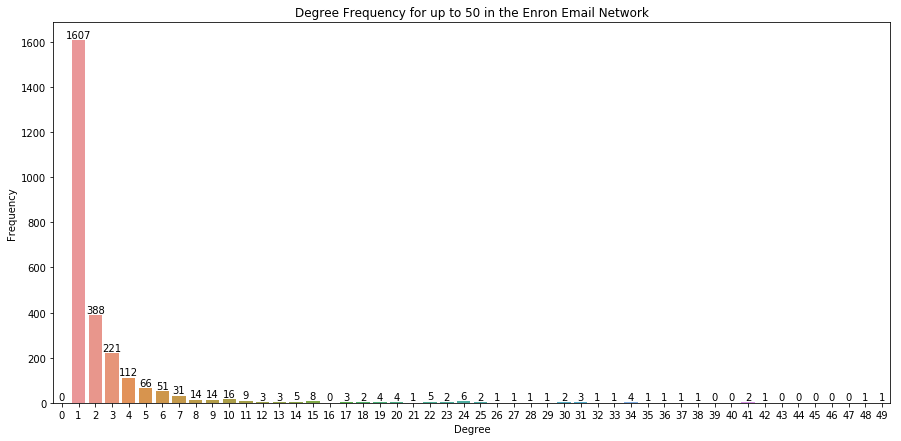

In [48]:
# Degree frequency histogram (50 degrees)
degree_hist = nx.degree_histogram(G)
bet = pd.DataFrame(dict(degree=range(50), frequency=degree_hist[:50]))
plt.figure(figsize=(15, 7))
deg_hist = sns.barplot("degree", "frequency", data=bet)
_ = plt.xlabel('Degree')
_ = plt.ylabel('Frequency')
_ = plt.title('Degree Frequency for up to 50 in the Enron Email Network')
for _, row in bet.iterrows():
    row = list(dict(row).values())
    deg_hist.text(row[0],row[1]+10, row[1], color='black', ha="center")
plt.show()

##### Assortativity

In [41]:
# Assortativity
assortativity = nx.degree_assortativity_coefficient(G)
print('Assortativity value:', round(assortativity, 2))
print('Network is strongly assortative') if assortativity >= 0.6 else (
    print('Network is somewhat assortative')
    if assortativity >= 0.2 else (print('Network is non assortative')
                                  if assortativity >= -0.2 else
                                  (print('Network is somewhat disassortative')
                                   if assortativity >= -0.6 else
                                   print('Network is strongly disassortative'))))

Assortativity value: -0.54
Network is somewhat disassortative


#### Mirco-level analysis

##### Degree centrality

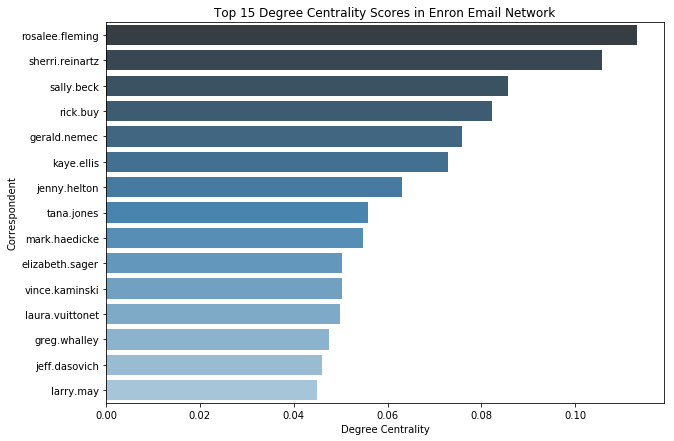

In [62]:
# Degree centrality
central = nx.degree_centrality(G)
name = []
centrality = []

for key, value in central.items():
    name.append(key)
    centrality.append(value)

cent = pd.DataFrame()    
cent['name'] = name
cent['centrality'] = centrality
cent = cent.sort_values(by='centrality', ascending=False)

plt.figure(figsize=(10, 7))
_ = sns.barplot(x='centrality', y='name', data=cent[:15], orient='h', palette='Blues_d')
_ = plt.xlabel('Degree Centrality')
_ = plt.ylabel('Correspondent')
_ = plt.title('Top 15 Degree Centrality Scores in Enron Email Network')
plt.show()

##### Betweenness centrality

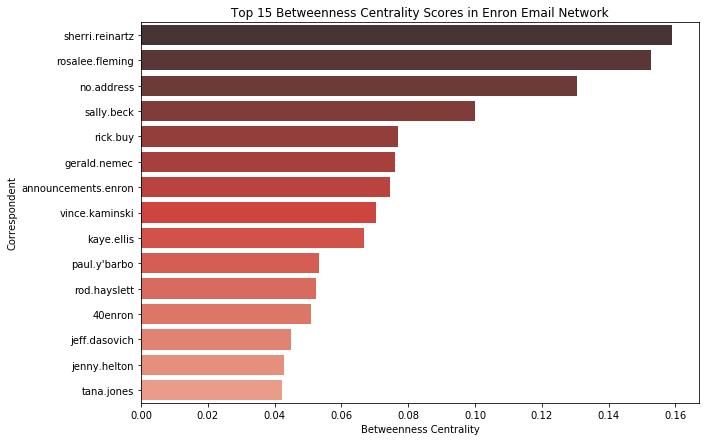

In [43]:
# Betweenness centrality
between = nx.betweenness_centrality(G)
name = []
betweenness = []

for key, value in between.items():
    name.append(key)
    betweenness.append(value)

bet = pd.DataFrame()
bet['name'] = name
bet['betweenness'] = betweenness
bet = bet.sort_values(by='betweenness', ascending=False)


plt.figure(figsize=(10, 7))
_ = sns.barplot(x='betweenness', y='name', data=bet[:15], orient='h', palette='Reds_d')
_ = plt.xlabel('Betweenness Centrality')
_ = plt.ylabel('Correspondent')
_ = plt.title('Top 15 Betweenness Centrality Scores in Enron Email Network')
plt.show()

##### Closeness centrality

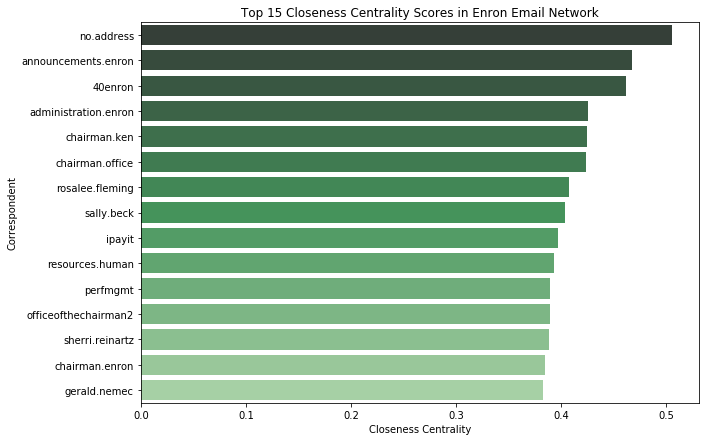

In [44]:
# Closeness centrality
close = nx.closeness_centrality(G)
name = []
closeness = []

for key, value in close.items():
    name.append(key)
    closeness.append(value)

bet = pd.DataFrame()
bet['name'] = name
bet['closeness'] = closeness
bet = bet.sort_values(by='closeness', ascending=False)

plt.figure(figsize=(10, 7))
_ = sns.barplot(x='closeness', y='name', data=bet[:15], orient='h', palette='Greens_d')
_ = plt.xlabel('Closeness Centrality')
_ = plt.ylabel('Correspondent')
_ = plt.title('Top 15 Closeness Centrality Scores in Enron Email Network')
plt.show()

##### Eigenvector centrality

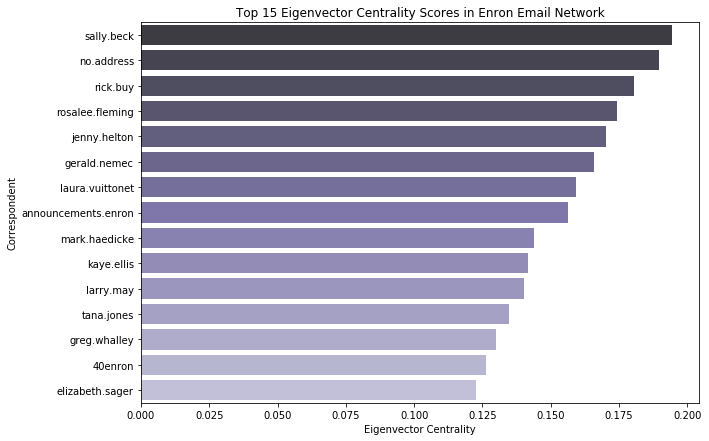

In [45]:
# Eigenvector centrality
eigen = nx.eigenvector_centrality(G)
name = []
eigenvector = []

for key, value in eigen.items():
    name.append(key)
    eigenvector.append(value)

bet = pd.DataFrame()
bet['name'] = name
bet['eigenvector'] = eigenvector
bet = bet.sort_values(by='eigenvector', ascending=False)

plt.figure(figsize=(10, 7))
_ = sns.barplot(x='eigenvector', y='name', data=bet[:15], orient='h', palette='Purples_d')
_ = plt.xlabel('Eigenvector Centrality')
_ = plt.ylabel('Correspondent')
_ = plt.title('Top 15 Eigenvector Centrality Scores in Enron Email Network')
plt.show()

##### Local clustering coeffecient

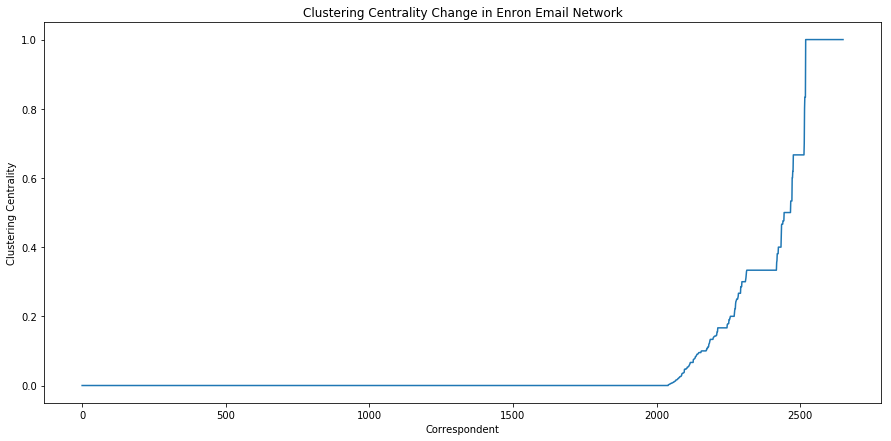

In [46]:
# Local clustering coeffecient
clust = nx.clustering(G)
clustering = []

for value in clust.values():
    clustering.append(value)

clustering.sort()

plt.figure(figsize=(15, 7))
# sns.set_style("darkgrid")
plt.plot(clustering)
plt.xlabel('Correspondent')
plt.ylabel('Clustering Centrality')
plt.title('Clustering Centrality Change in Enron Email Network')
plt.show()

#### Meso-level analysis

##### Community detection

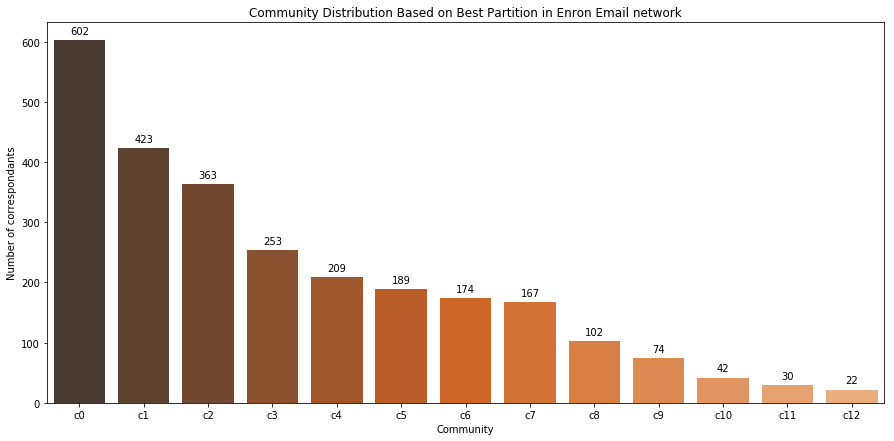

In [78]:
# Community detection based on best partition
com = community.best_partition(G)

# Count communities members
communities = Counter(list(com.values()))
communities = dict(communities.items())
bet = pd.DataFrame()
bet['community'] = list(map(lambda x: 'c'+str(x), list(communities.keys())))
bet['frequency'] = sorted(list(communities.values()), reverse=True)

# Plot Community Distribution
plt.figure(figsize=(15, 7))
com_g = sns.barplot(x='community', y='frequency', data=bet, orient='v', palette="Oranges_d")
_ = plt.xlabel('Community')
_ = plt.ylabel('Number of correspondants')
_ = plt.title('Community Distribution Based on Best Partition in Enron Email network')
for index, row in bet.iterrows():
    row = list(dict(row).values())
    row[0] = index
    com_g.text(row[0],row[1]+10, row[1], color='black', ha="center")

plt.show()

### Draw the network

In order to get a bird view of the network, we often visualize it using draw functions. Draw your network and choose the best layout to enhance the visualization.   

Networkx offers the possibility of drawing your Graph, but you can choose other libraries (You can even use D3 for interactive visualization).  

You can read the associated documentation or visit their gallery to go further. 

<hr>

#### Visualization tool

- Visualizing the network using `networkx`'s standard visualization tool results in an ugly unreadable hairball. Tweaking the parameters and playing with the layout doesn't change much.

- We will instead use `Gephi` since it offers more flexibility.

- We will use the `GephiStreaming` `python` package to stream the commands from the python interpreter (in a separate command line since `Jupyter Notebook` is not supported).

<hr>

Throughout the visualization process, we use a gravity layout and color the nodes with regards to their modularity class obtained in the community detection stage. As for nodes scaling, we envisage different metrics:

###### Degree

We scale Nodes by degree centrality to emphasis the number of emails per individual.

<img src="svg/final/degr.svg" />

##### Betweenness

We do the same for betweenness centrality to emphasis the most central nodes in the Enron network.

<img src="svg/final/betr.svg" />

###### Closeness

Finally, we scale by closeness centrality to accentuate the nodes that are more influential and have better access to information within the network.

<img src="svg/final/clor.svg" />

###### Extra

Circular layout (nodes scaled by betweenness):

<img src="svg/circular_layout/circbet.svg" />

<b style="font-size=200%">NB:</b> More visualizations are available in the svg folder.

### Save the network

Save the resulting network in a 'gexf' file format. 
Save your metrics in a .csv file.

In [50]:
# Save network to gexf
nx.write_gexf(G, 'enron_network.gexf')

In [102]:
# Save micro & meso metrics to csv
'''
CSV file format (headers):
node, degree_centrality, betweenness_centrality, closeness_centrality,
    eigenvector_centrality, local_clustering_coefficient, modularity_class
'''

# 1. construct a pandas DataFrame:
micro_metrics = pd.DataFrame()
'''we sort all dictionaries before accessing the matrics to ensure we get the right value for each node'''
micro_metrics['node'] = list((dict(sorted(central.items()))).keys())
micro_metrics['degree_cent'] = list(
    (dict(sorted(central.items()))).values())
micro_metrics['betweenness_cent'] = list(
    (dict(sorted(between.items()))).values())
micro_metrics['closeness_cent'] = list(
    (dict(sorted(close.items()))).values())
micro_metrics['eigenvector_cent'] = list(
    (dict(sorted(eigen.items()))).values())
micro_metrics['clustering_coeff'] = list((dict(
    sorted(clust.items()))).values())
micro_metrics['modularity_class'] = list((dict(sorted(com.items()))).values())

# 2. display the DataFrame:
display(micro_metrics.head(10))

# 3. save to CSV:
micro_header = [
    'node',
    'degree_centrality',
    'betweenness_centrality',
    'closeness_centrality',
    'eigenvector_centrality',
    'local_clustering_coefficient',
    'modularity_class'
]
micro_metrics.to_csv('enron_micro_metrics.csv', index=False, header=micro_header)

,node,degree_cent,betweenness_cent,closeness_cent,eigenvector_cent,clustering_coeff,modularity_class
0,2.ews,0.000378,0.000000,0.263661,0.003691,0.000000,0
1,40ect,0.000755,0.000004,0.272727,0.004864,0.000000,1
2,40ees,0.000378,0.000000,0.267603,0.002102,0.000000,2
3,40enron,0.015855,0.051022,0.462304,0.126151,0.062718,1
4,Andrea.Ring,0.000378,0.000000,0.255596,0.001581,0.000000,3
5,Andy.Zipper,0.000378,0.000000,0.268036,0.003242,0.000000,3
6,Cheryl.Nelson,0.000378,0.000000,0.269071,0.004739,0.000000,0
7,Chris.Germany,0.000378,0.000000,0.262173,0.002670,0.000000,3
8,Clint.Dean,0.000378,0.000000,0.257409,0.002283,0.000000,5
9,Darron.C.Giron,0.000378,0.000000,0.255967,0.002695,0.000000,3


In [103]:
# Save macro metrics to csv
'''
CSV file format (headers):
density, average_shortest_path, diameter, average_clustering_coeﬀicient, assortativity
'''

# 1. construct a pandas DataFrame:
macro_metrics = pd.DataFrame()
macro_metrics['density'] = [density]
macro_metrics['shortest_path'] = [avg_spl]
macro_metrics['diameter'] = [diameter]
macro_metrics['clustering_coeff'] = [clust_coef]
macro_metrics['assortativity'] = [assortativity]

# 2. display the DataFrame:
display(macro_metrics)

# 3. save to CSV:
macro_header = ['density', 'average_shortest_path', 'diameter', 'average_clustering_coeﬀicient', 'assortativity']
macro_metrics.to_csv('enron_macro_metrics.csv', index=False, header=macro_header)

,density,shortest_path,diameter,clustering_coeff,assortativity
0,0.001701,3.583623,5,0.096902,-0.544078


End of assignment.